In [1]:
import pandas as pd

df = pd.read_csv("./data/stj_sts.csv")
df.head()

,sentence_A,sentence_B,score,range,SPLIT
0,ADMINISTRATIVO. RECURSO ORDINÁRIO EM MANDADO D...,ADMINISTRATIVO. RECURSO ORDINÁRIO EM MANDADO D...,4.676405,4,TRAIN
1,ADMINISTRATIVO. AGRAVO REGIMENTAL. RECURSO ORD...,ADMINISTRATIVO E PROCESSUAL CIVIL. SEGUNDOS EM...,4.540016,4,TEST
2,ADMINISTRATIVO. RECURSO ORDINÁRIO EM MANDADO D...,ADMINISTRATIVO E PROCESSUAL CIVIL. SEGUNDOS EM...,4.597874,4,TRAIN
3,ADMINISTRATIVO. AGRAVO REGIMENTAL. RECURSO ORD...,ADMINISTRATIVO. RECURSO ORDINÁRIO EM MANDADO D...,4.724089,4,TEST
4,ADMINISTRATIVO E PROCESSUAL CIVIL. SEGUNDOS EM...,ADMINISTRATIVO. RECURSO ORDINÁRIO EM MANDADO D...,4.686756,4,TRAIN


In [2]:
from evaluate import load
bertscore = load("bertscore")


/home/jayr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
test = df[df["SPLIT"] == "TEST"]
test.info(0)

<class 'pandas.core.frame.DataFrame'>
Index: 10814 entries, 1 to 51424
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sentence_A  10814 non-null  object 
 1   sentence_B  10814 non-null  object 
 2   score       10814 non-null  float64
 3   range       10814 non-null  int64  
 4   SPLIT       10814 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 506.9+ KB


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

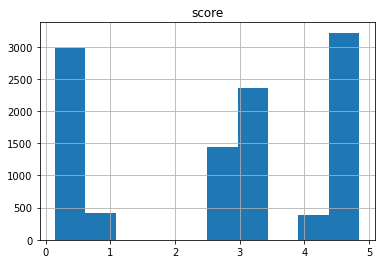

In [20]:
# histogram for score

test.hist("score")

In [36]:
# make a stratified sample of 50 rows. Uses the score column to stratify. Consider the score is a float

bins = [0, 1, 2, 3, 4, 5]
test['bin'] = pd.cut(test['score'], bins=bins)

total_samples = 50
bin_counts = test['bin'].value_counts(normalize=True).sort_index()
samples_per_bin = (bin_counts * total_samples).round().astype(int)

# Adjust for rounding issues
samples_per_bin.iloc[-stratified_sample1] += total_samples - samples_per_bin.sum()

# Perform stratified sampling based on the bins
stratified_sample = test.groupby('bin', group_keys=False).apply(lambda x: x.sample(n=samples_per_bin.loc[x.name]))

# Drop the 'bin' column as it was just for stratification
stratified_sample = stratified_sample.drop(columns=['bin'])


/tmp/ipykernel_210545/399145726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['bin'] = pd.cut(test['score'], bins=bins)
/tmp/ipykernel_210545/399145726.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stratified_sample = test.groupby('bin', group_keys=False).apply(lambda x: x.sample(n=samples_per_bin.loc[x.name]))
/tmp/ipykernel_210545/399145726.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operati

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

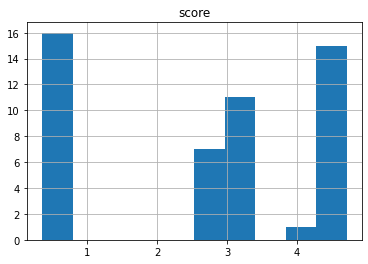

In [39]:
stratified_sample.hist("score")

In [40]:
stratified_sample.to_csv("./data/sample.csv", index=False)

In [41]:
references = stratified_sample["sentence_A"].values
predictions = stratified_sample["sentence_B"].values

In [42]:
results = bertscore.compute(predictions=predictions, references=references, lang="en",show_progress=True)

In [7]:
results

{'precision': [0.8207067251205444,
  0.885125994682312,
  0.8431960344314575,
  0.8172149062156677,
  0.8463836908340454,
  0.8470879197120667,
  0.8280817866325378,
  0.8383252024650574,
  0.8346685171127319,
  0.8314874768257141,
  0.8486172556877136,
  0.8288367390632629,
  0.8664535880088806,
  0.8372492790222168,
  0.8573464751243591,
  0.8286499381065369,
  0.8373159170150757,
  0.8578878045082092,
  0.8439999222755432,
  0.8378143906593323],
 'recall': [0.815623939037323,
  0.8924576044082642,
  0.7884061336517334,
  0.7950211763381958,
  0.8360767960548401,
  0.8029350638389587,
  0.7654871344566345,
  0.8260306715965271,
  0.8307565450668335,
  0.8263407945632935,
  0.8367154598236084,
  0.8259488344192505,
  0.8674034476280212,
  0.8325390219688416,
  0.8492498397827148,
  0.8277750611305237,
  0.840265154838562,
  0.8407460451126099,
  0.8684128522872925,
  0.8369005918502808],
 'f1': [0.8181574940681458,
  0.8887767195701599,
  0.8148811459541321,
  0.8059653043746948,
  0.

In [8]:
from utils import calculate_correlation

In [47]:
human_scores = stratified_sample["score"].values
pred_scores = results["f1"]

calculate_correlation(human_scores, pred_scores, {})

{'pearson': 0.38474227171194963,
 'spearman': 0.42770708283313325,
 'kendalltau': 0.2963265306122449}

{'pearson': 0.5017214430755953,
 'spearman': 0.4812030075187969,
 'kendalltau': 0.3157894736842105}